In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [4]:

data = np.load('development_numpy/development.npy', allow_pickle=True)
metadata = pd.read_csv('metadata/development.csv')
feature_names_mapping = pd.read_csv('metadata/idx_to_feature_name.csv')

labels = metadata['word'].values

subsample_fraction = 0.7
X_subsample, _, y_subsample, _, snippet_ids_subsample, _ = train_test_split(
    data, labels, np.arange(len(metadata)), train_size=subsample_fraction, random_state=42)

n_samples, n_features, n_time = X_subsample.shape
X_subsample_flat = X_subsample.reshape(n_samples, n_features * n_time)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_subsample_flat, y_subsample, test_size=0.3, random_state=42, stratify=y_subsample)


In [5]:
# smote for ballancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_val, y_train_val)

unique, counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")


Class distribution after SMOTE: {'Alarm': 297, 'Brötchen': 297, 'Fernseher': 297, 'Haus': 297, 'Heizung': 297, 'Leitung': 297, 'Licht': 297, 'Lüftung': 297, 'Ofen': 297, 'Radio': 297, 'Schraube': 297, 'Spiegel': 297, 'Staubsauger': 297, 'an': 297, 'aus': 297, 'kann': 297, 'nicht': 297, 'offen': 297, 'other': 297, 'warm': 297, 'wunderbar': 297}


In [6]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


In [7]:
# feature selection
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
feature_selector.fit(X_train_scaled, y_resampled)
sfm = SelectFromModel(feature_selector, threshold="mean")
X_train_important = sfm.transform(X_train_scaled)
X_test_important = sfm.transform(X_test_scaled)


In [11]:
# Display selected features
selected_features = sfm.get_support(indices=True)
print("Selected Features Indices:", selected_features)

Selected Features: 1891
Selected Features Indices: [   9   11   12 ... 7686 7687 7688]


In [13]:
# predicts label
def evaluate_model(model):
    y_pred = model.predict(X_test_important)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Visualize the confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


              precision    recall  f1-score   support

       Alarm       0.81      0.82      0.82       577
    Brötchen       0.89      0.95      0.92       582
   Fernseher       0.90      0.93      0.91       588
        Haus       0.84      0.84      0.84       585
     Heizung       0.92      0.92      0.92       584
     Leitung       0.91      0.92      0.92       581
       Licht       0.90      0.91      0.90       584
     Lüftung       0.94      0.92      0.93       578
        Ofen       0.68      0.71      0.69       585
       Radio       0.89      0.90      0.89       582
    Schraube       0.93      0.91      0.92       585
     Spiegel       0.95      0.97      0.96       582
 Staubsauger       0.95      0.93      0.94       579
          an       0.87      0.87      0.87       581
         aus       0.85      0.84      0.85       584
        kann       0.88      0.88      0.88       580
       nicht       0.92      0.89      0.91       588
       offen       0.70    

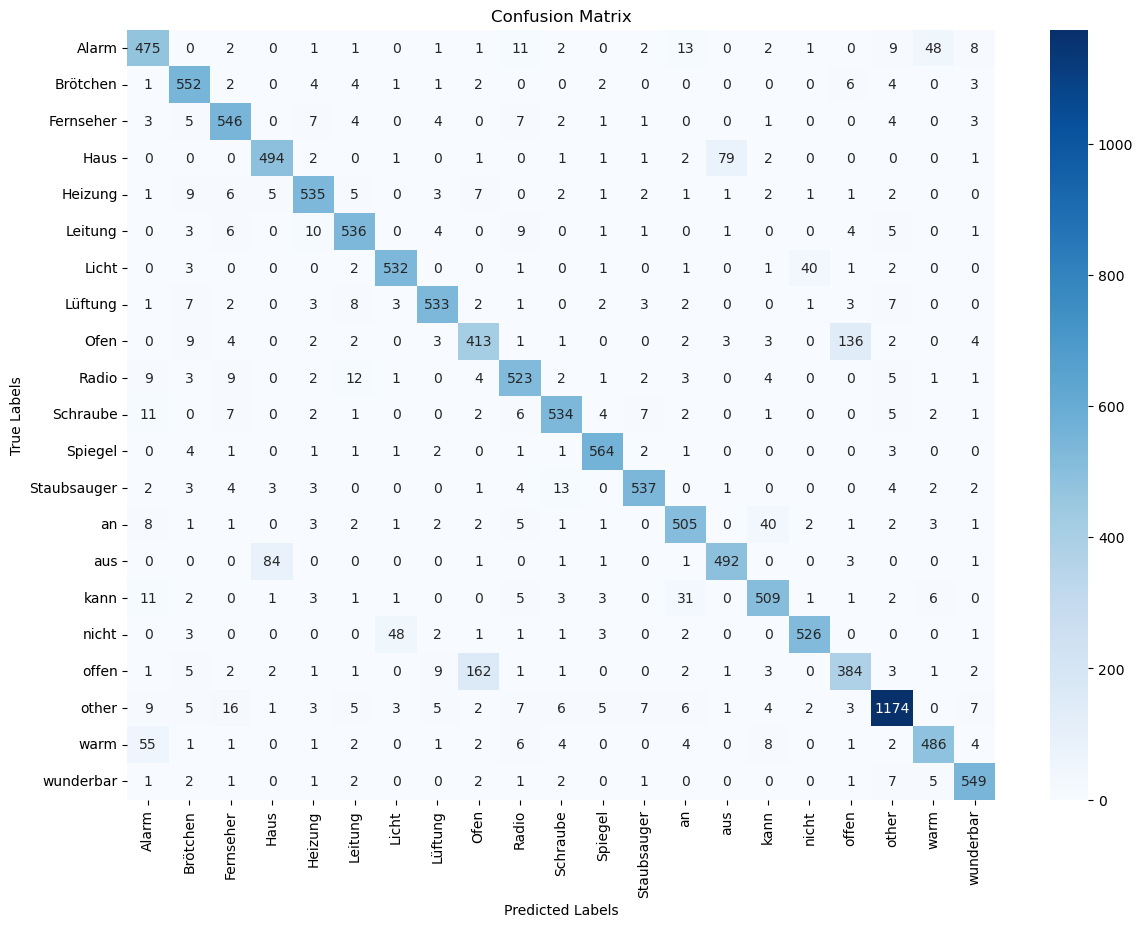

In [14]:
# train svm
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_important, y_resampled)

evaluate_model(svm_model)


              precision    recall  f1-score   support

       Alarm       0.90      0.95      0.92       577
    Brötchen       0.96      0.98      0.97       582
   Fernseher       0.94      0.97      0.95       588
        Haus       0.85      0.90      0.87       585
     Heizung       0.95      0.96      0.95       584
     Leitung       0.96      0.94      0.95       581
       Licht       0.86      0.84      0.85       584
     Lüftung       0.96      0.97      0.96       578
        Ofen       0.80      0.81      0.80       585
       Radio       0.94      0.98      0.96       582
    Schraube       0.97      0.98      0.97       585
     Spiegel       0.96      0.98      0.97       582
 Staubsauger       0.99      0.96      0.97       579
          an       0.88      0.90      0.89       581
         aus       0.90      0.84      0.87       584
        kann       0.89      0.91      0.90       580
       nicht       0.84      0.88      0.86       588
       offen       0.79    

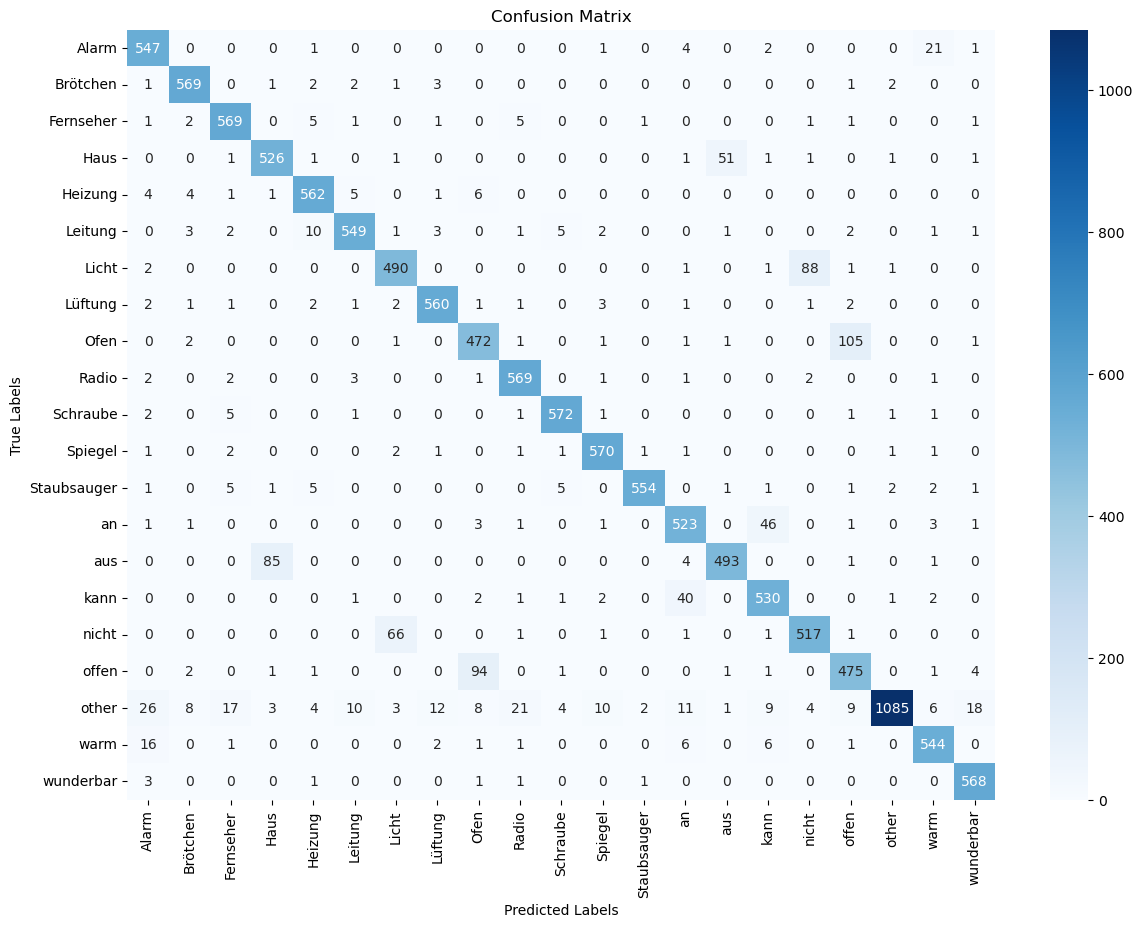

In [15]:
# train knn
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train_important, y_resampled)

evaluate_model(knn_model)



              precision    recall  f1-score   support

       Alarm       0.93      0.88      0.90       577
    Brötchen       0.97      0.95      0.96       582
   Fernseher       0.96      0.96      0.96       588
        Haus       0.92      0.90      0.91       585
     Heizung       0.95      0.93      0.94       584
     Leitung       0.93      0.95      0.94       581
       Licht       0.93      0.89      0.91       584
     Lüftung       0.97      0.91      0.94       578
        Ofen       0.78      0.77      0.77       585
       Radio       0.94      0.96      0.95       582
    Schraube       0.94      0.96      0.95       585
     Spiegel       0.98      0.96      0.97       582
 Staubsauger       0.97      0.96      0.96       579
          an       0.96      0.87      0.91       581
         aus       0.90      0.92      0.91       584
        kann       0.88      0.95      0.92       580
       nicht       0.90      0.92      0.91       588
       offen       0.75    

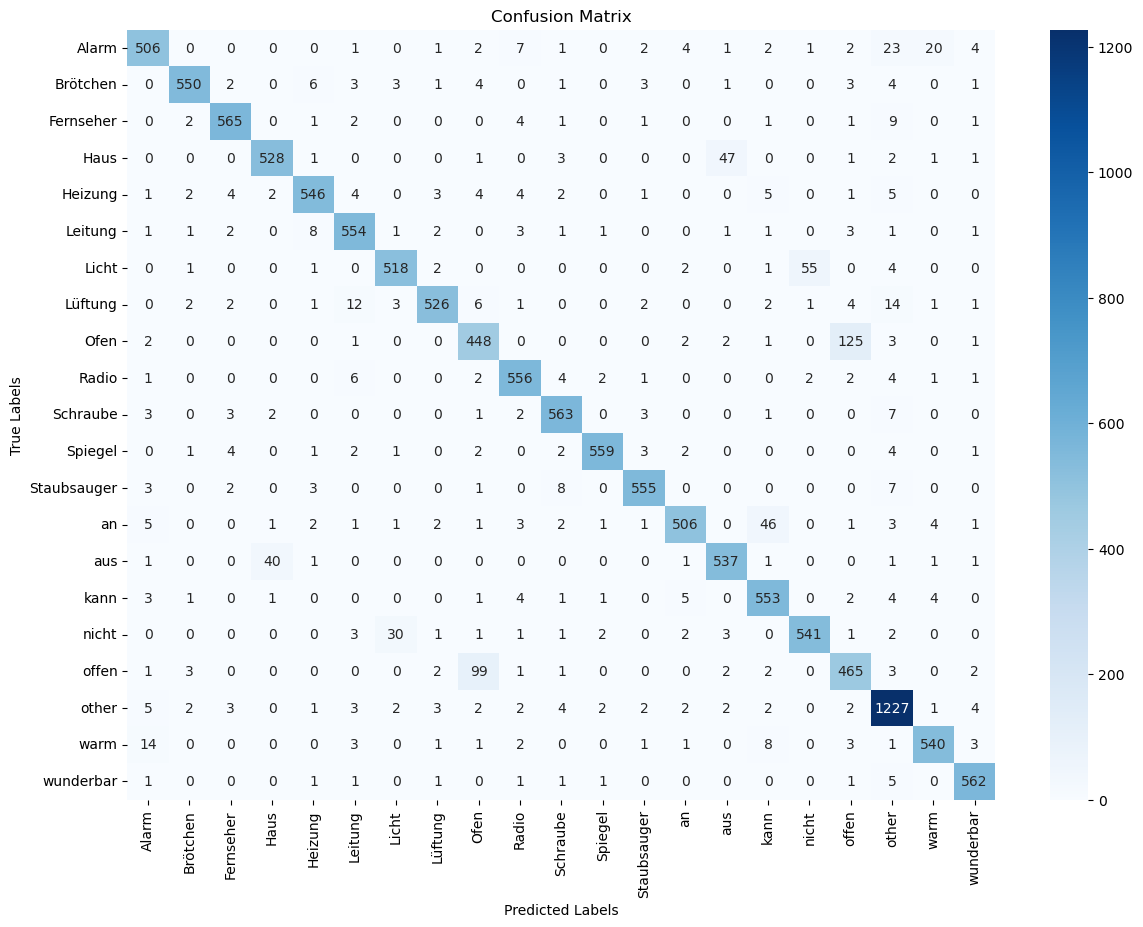

In [16]:
# train nn
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
nn_model.fit(X_train_important, y_resampled)

evaluate_model(nn_model)


In [17]:
def predict_word(svm_model, scaler, sfm, word_index, test_data, test_labels):
    word_features = test_data[word_index].reshape(1, -1)
    word_features_scaled = scaler.transform(word_features)
    
    word_features_important = sfm.transform(word_features_scaled)
    
    prediction = svm_model.predict(word_features_important)
    
    return prediction[0]

sample_indices = np.random.choice(len(y_test), 10, replace=False)
for idx in sample_indices:
    example_word = y_test[idx]
    predicted_label = predict_word(svm_model, scaler, sfm, idx, X_test_scaled, y_test)
    print(f"True label: {example_word} | Predicted label: {predicted_label}")


True label: Leitung | Predicted label: Leitung
True label: other | Predicted label: other
True label: Fernseher | Predicted label: Brötchen
True label: Spiegel | Predicted label: Spiegel
True label: nicht | Predicted label: nicht
True label: kann | Predicted label: kann
True label: nicht | Predicted label: nicht
True label: offen | Predicted label: kann
True label: Ofen | Predicted label: an
True label: other | Predicted label: other
